# Deep Markov Model

In [1]:
import time
import pickle

import torch
import torch.nn as nn

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine

from pyro.optim import ClippedAdam
from pyro.infer import SVI, Trace_ELBO

In [2]:
# from https://github.com/pyro-ppl/pyro/blob/c7f77f882c54cb8fc6bf463833c85857109ebc82/examples/dmm/polyphonic_data_loader.py
def reverse_sequences(mini_batch, seq_lengths):
    reversed_mini_batch = torch.zeros_like(mini_batch)
    for b in range(mini_batch.size(0)):
        T = seq_lengths[b]
        time_slice = torch.arange(T - 1, -1, -1, device=mini_batch.device)
        reversed_sequence = torch.index_select(mini_batch[b, :, :], 0, time_slice)
        reversed_mini_batch[b, 0:T, :] = reversed_sequence
    return reversed_mini_batch

def pad_and_reverse(rnn_output, seq_lengths):
    rnn_output, _ = nn.utils.rnn.pad_packed_sequence(rnn_output, batch_first=True)
    reversed_output = reverse_sequences(rnn_output, seq_lengths)
    return reversed_output

# this function returns a 0/1 mask that can be used to mask out a mini-batch
# composed of sequences of length `seq_lengths`
def get_mini_batch_mask(mini_batch, seq_lengths):
    mask = torch.zeros(mini_batch.shape[0:2])
    for b in range(mini_batch.shape[0]):
        mask[b, 0:seq_lengths[b]] = torch.ones(seq_lengths[b])
    return mask


# this function prepares a mini-batch for training or evaluation.
# it returns a mini-batch in forward temporal order (`mini_batch`) as
# well as a mini-batch in reverse temporal order (`mini_batch_reversed`).
# it also deals with the fact that packed sequences (which are what what we
# feed to the PyTorch rnn) need to be sorted by sequence length.
def get_mini_batch(mini_batch_indices, sequences, seq_lengths, cuda=False):
    # get the sequence lengths of the mini-batch
    seq_lengths = seq_lengths[mini_batch_indices]
    # sort the sequence lengths
    _, sorted_seq_length_indices = torch.sort(seq_lengths)
    sorted_seq_length_indices = sorted_seq_length_indices.flip(0)
    sorted_seq_lengths = seq_lengths[sorted_seq_length_indices]
    sorted_mini_batch_indices = mini_batch_indices[sorted_seq_length_indices]

    # compute the length of the longest sequence in the mini-batch
    T_max = torch.max(seq_lengths)
    # this is the sorted mini-batch
    mini_batch = sequences[sorted_mini_batch_indices, 0:T_max, :]
    # this is the sorted mini-batch in reverse temporal order
    mini_batch_reversed = reverse_sequences(mini_batch, sorted_seq_lengths)
    # get mask for mini-batch
    mini_batch_mask = get_mini_batch_mask(mini_batch, sorted_seq_lengths)

    # cuda() here because need to cuda() before packing
    if cuda:
        mini_batch = mini_batch.cuda()
        mini_batch_mask = mini_batch_mask.cuda()
        mini_batch_reversed = mini_batch_reversed.cuda()

    # do sequence packing
    mini_batch_reversed = nn.utils.rnn.pack_padded_sequence(mini_batch_reversed,
                                                            sorted_seq_lengths,
                                                            batch_first=True)

    return mini_batch, mini_batch_reversed, mini_batch_mask, sorted_seq_lengths

## モデル

In [3]:
class Emitter(nn.Module):
    # p(x_t | z_t)
    def __init__(self, input_dim, z_dim, emission_dim):
        super().__init__()
        self.linear_z_to_hidden1 = nn.Linear(z_dim, emission_dim)
        self.linear_hidden1_to_hidden2 = nn.Linear(emission_dim, emission_dim)
        self.linear_hidden2_to_input = nn.Linear(emission_dim, input_dim)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, z_i):
        h1 = self.relu(self.linear_z_to_hidden1(z_i))
        h2 = self.relu(self.linear_hidden1_to_hidden2(h1))
        ps = self.sigmoid(self.linear_hidden2_to_input(h2))
        return ps

In [4]:
class GatedTransition(nn.Module):
    #  p(z_t | z_{t-1})
    def __init__(self, z_dim, transition_dim):
        super().__init__()
        # Neural Netwark
        ## Gate: g
        self.linear_gate_z_to_g1 = nn.Linear(z_dim, transition_dim)
        self.linear_gate_g1_to_g2 = nn.Linear(transition_dim, z_dim)
        ## Hidden: h
        self.linear_hidden_z_to_h1 = nn.Linear(z_dim, transition_dim)
        self.linear_hidden_h1_to_h2 = nn.Linear(transition_dim, z_dim)
        ## loc, scale
        self.linear_scale_z_to_mean = nn.Linear(z_dim, z_dim)
        self.linear_loc_h2_to_loc = nn.Linear(z_dim, z_dim)
        
        # Init params
        self.linear_loc_h2_to_loc.weight.data = torch.eye(z_dim)
        self.linear_loc_h2_to_loc.bias.data = torch.zeros(z_dim)
        
        # Non-linearities functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.softplus = nn.Softplus()
    
    def forward(self, z_t_1):
        # Gate functions
        g1 = self.relu(self.linear_gate_z_to_g1(z_t_1))
        g2 = self.relu(self.linear_gate_g1_to_g2(g1))
        
        # h(proposed mean) functions
        h1 = self.relu(self.linear_hidden_z_to_h1(z_t_1))
        h2 = self.linear_hidden_h1_to_h2(h1)
        
        # Loc, Scale
        loc = (1 - g2) * self.linear_scale_z_to_mean(z_t_1) + g2 *h2
        scale = self.softplus(self.linear_loc_h2_to_loc(self.relu(h2)))
        
        return loc, scale

In [5]:
class Combiner(nn.Module):
    def __init__(self, z_dim, rnn_dim):
        super().__init__()
        # linear functions
        self.linear_z_to_hidden = nn.Linear(z_dim, rnn_dim)
        self.linear_hidden_to_loc = nn.Linear(rnn_dim, z_dim)
        self.linear_hidden_to_scale = nn.Linear(rnn_dim, z_dim)
        
        # non-linear functions
        self.tanh = nn.Tanh()
        self.softplus = nn.Softplus()
    
    def forward(self, z_t_1, h_rnn):
        # NOTE: 1/2はどこからきた
        h_combined = 1/2 * (self.tanh(self.linear_z_to_hidden(z_t_1)) + h_rnn)
        
        # Loc, Scale
        loc = self.linear_hidden_to_loc(h_combined)
        scale = self.softplus(self.linear_hidden_to_scale(h_combined))
        
        return loc, scale

In [6]:
class DMM(nn.Module):
    def __init__(self,
                           input_dim = 88,
                           z_dim = 100,
                           emission_dim = 100,
                           transition_dim = 200,
                           rnn_dim=600,
                           rnn_dropout_rate=0.0,
                           num_iafs=0,
                           iaf_dim=50,
                          use_cuda=False):
        super().__init__()
        # Model
        ## Modules
        self.emitter = Emitter(input_dim, z_dim, emission_dim)
        self.trans = GatedTransition(z_dim, transition_dim)

        ## Init params
        self.z_0 = nn.Parameter(torch.zeros(z_dim))

        # Guide
        ## Modules
        self.combiner = Combiner(z_dim, rnn_dim)
        self.rnn = nn.RNN(input_size=input_dim, 
                                       hidden_size=rnn_dim,
                                       nonlinearity='relu',
                                       batch_first=True,
                                       bidirectional=False,
                                       num_layers=1,
                                       dropout=rnn_dropout_rate)

        ## Init params
        self.z_q_0 = nn.Parameter(torch.zeros(z_dim))
        self.h_0 = nn.Parameter(torch.zeros(1, 1, rnn_dim)) # RNNの潜在変数

        self.use_cuda = use_cuda
        # if on gpu cuda-ize all pytorch (sub)modules
        if use_cuda:
            self.cuda()

    def model(self, 
                       mini_batch, # (batch_size, seq_length, feature_size)
                       mini_batch_reversed, 
                       mini_batch_mask, # (batch_size, seq_length)
                       mini_batch_seq_lengths,
                       annealing_factor=1.0):
        
        T_max = mini_batch.size(1)
        
        pyro.module("dmm", self) # 自身のクラス(DMM)について記述

        # z_prev に z_0を設定
        z_prev = self.z_0.expand(mini_batch.size(0), self.z_0.size(0))

        # 各データ系列から独立しているのでplateを使う
        with pyro.plate("z_minibatch", len(mini_batch)):
            # 潜在変数z_tと観測データxのサンプリングを行う
            for t in range(1, T_max + 1):
                # 多次元ガウス分布p(z_t | z_{t-1})のパラメータμとσを求める
                z_loc, z_scale = self.trans(z_prev)
                    
                #　z_t ~ Normal(z_t | z_{t-1})のサンプリングをパラメータを用いて行う
                # TODO: これ見る　http://pyro.ai/examples/effect_handlers.html
                with poutine.scale(None, annealing_factor):
                    z_t = pyro.sample("z_%d" % t,
                                          dist.Normal(z_loc, z_scale)
                                          .mask(mini_batch_mask[:, t - 1:t])
                                          .to_event(1))

                # ベルヌーイ分布p(x_t|z_t)のパラメータを求める
                emission_probs_t = self.emitter(z_t)
 
                # x_t ~ Bern(x_t|z_t)のサンプリングをパラメータを用いて行う
                pyro.sample("obs_x_%d" % t,
                            dist.Bernoulli(emission_probs_t)
                                .mask(mini_batch_mask[:, t - 1:t])
                                .to_event(1),
                            obs=mini_batch[:, t - 1, :])
                
                #  z_prevの更新
                z_prev = z_t

    def guide(self, 
                       mini_batch, # (batch_size, seq_length, feature_size)
                       mini_batch_reversed, 
                       mini_batch_mask, # (batch_size, seq_length)
                       mini_batch_seq_lengths,
                       annealing_factor=1.0):
        T_max = mini_batch.size(1)
        
        pyro.module("dmm", self) # 自身のクラス(DMM)について記述

        # h_0
        h_0_contig = self.h_0.expand(1, mini_batch.size(0),
                                                              self.rnn.hidden_size).contiguous()

        # RNNの出力
        rnn_output, _ = self.rnn(mini_batch_reversed, h_0_contig)
        rnn_output = pad_and_reverse(rnn_output, mini_batch_seq_lengths)

        # z_prev に z_q_0を設定
        z_prev = self.z_q_0.expand(mini_batch.size(0), self.z_q_0.size(0))

        # 各データ系列から独立しているのでplateを使う
        with pyro.plate("z_minibatch", len(mini_batch)):
            # 潜在変数z_tと観測データxのサンプリングを行う
            for t in range(1, T_max + 1):
                # 多次元ガウス分布q(z_t | z_{t-1}, x_{t:T})の分布を求める
                z_loc, z_scale = self.combiner(z_prev, rnn_output[:, t - 1, :])
                z_dist = dist.Normal(z_loc, z_scale)
                    
                #　z_t ~ q(z_t | z_{t-1}, x_{t:T})
                with pyro.poutine.scale(None, annealing_factor):
                    z_t = pyro.sample("z_%d" % t,
                                                      z_dist.mask(mini_batch_mask[:, t - 1:t])
                                                     .to_event(1))                
                #  z_prevの更新
                z_prev = z_t

## SVI

In [7]:
device = "cuda"

dmm = DMM(use_cuda=device)

adam_params = {
    "lr": 0.01, 
    "betas": (0.9, 0.999),
    "clip_norm": 0,
    "lrd": 0,
    "weight_decay": 0
}

optimizer = ClippedAdam(adam_params)
svi = SVI(dmm.model, dmm.guide, optimizer, Trace_ELBO())

### データのロード

In [8]:
import numpy as np

from os.path import exists, join
from observations import jsb_chorales

def process_data(base_path, filename, T_max=160, min_note=21, note_range=88):
    output = join(base_path, filename)
    if exists(output):
        return

    print("processing raw polyphonic music data...")
    data = jsb_chorales(base_path)
    processed_dataset = {}
    for split, data_split in zip(['train', 'test', 'valid'], data):
        processed_dataset[split] = {}
        n_seqs = len(data_split)
        processed_dataset[split]['sequence_lengths'] = np.zeros((n_seqs), dtype=np.int32)
        processed_dataset[split]['sequences'] = np.zeros((n_seqs, T_max, note_range))
        for seq in range(n_seqs):
            seq_length = len(data_split[seq])
            processed_dataset[split]['sequence_lengths'][seq] = seq_length
            for t in range(seq_length):
                note_slice = np.array(list(data_split[seq][t])) - min_note
                slice_length = len(note_slice)
                if slice_length > 0:
                    processed_dataset[split]['sequences'][seq, t, note_slice] = np.ones((slice_length))
    pickle.dump(processed_dataset, open(output, "wb"))
    print("dumped processed data to %s" % output)


! pip install Observations
base_path = '../data'
process_data(base_path, "jsb_processed.pkl")

In [9]:
mini_batch_size = 20

jsb_file_loc = "../data/jsb_processed.pkl"
data = pickle.load(open(jsb_file_loc, "rb"))
training_seq_lengths = torch.tensor(data['train']['sequence_lengths']).to(device)
training_data_sequences = torch.tensor(data['train']['sequences']).float().to(device)

test_seq_lengths = torch.tensor(data['test']['sequence_lengths'])
test_data_sequences = torch.tensor(data['test']['sequences']).float()

val_seq_lengths = torch.tensor(data['valid']['sequence_lengths'])
val_data_sequences = torch.tensor(data['valid']['sequences']).float()

N_train_data = len(training_seq_lengths)
N_train_time_slices = float(training_seq_lengths.sum())
N_mini_batches = int(N_train_data / mini_batch_size +
                     int(N_train_data % mini_batch_size > 0))

In [10]:
def process_minibatch(epoch,
                                         which_mini_batch,
                                         shuffled_indices,
                                         annealing_epochs=1000,
                                         minimum_annealing_factor=0.1,
                                         mini_batch_size=20,
                                         cuda=True):
    if annealing_epochs > 0 and epoch < annealing_epochs:
        # KL アニーリングの適用
        min_af = minimum_annealing_factor
        annealing_factor = min_af + (1.0 - min_af) * \
            (float(which_mini_batch + epoch * N_mini_batches + 1) /
             float(annealing_epochs * N_mini_batches))
    else:
        annealing_factor = 1.0

    # ミニバッチのインデックスの切り出し
    mini_batch_start = (which_mini_batch * mini_batch_size)
    mini_batch_end = np.min([(which_mini_batch + 1) * mini_batch_size,
                             N_train_data])
    mini_batch_indices = torch.tensor(shuffled_indices[mini_batch_start:mini_batch_end]).to(cuda)
    # ミニバッチの取得
    mini_batch, mini_batch_reversed, mini_batch_mask, mini_batch_seq_lengths \
        = get_mini_batch(mini_batch_indices, training_data_sequences,
                              training_seq_lengths, cuda=cuda)
    # 損失関数の計算
    loss = svi.step(mini_batch, mini_batch_reversed, mini_batch_mask,
                     mini_batch_seq_lengths, annealing_factor)
    return loss

In [43]:
n_eval_samples = 1
def rep(x):
    return np.repeat(x, n_eval_samples, axis=0)

# get the validation/test data ready for the dmm: pack into sequences, etc.
val_seq_lengths = rep(val_seq_lengths)
test_seq_lengths = rep(test_seq_lengths)

val_batch, val_batch_reversed, val_batch_mask, val_seq_lengths = get_mini_batch(
    np.arange(n_eval_samples * val_data_sequences.shape[0]), rep(val_data_sequences),
    val_seq_lengths, cuda=device)


test_batch, test_batch_reversed, test_batch_mask, test_seq_lengths = \
    get_mini_batch(np.arange(n_eval_samples * test_data_sequences.shape[0]),
                        rep(test_data_sequences),
                        test_seq_lengths, cuda=device)

def do_evaluation():
    dmm.rnn.eval()

    val_nll = svi.evaluate_loss(val_batch, val_batch_reversed, val_batch_mask,
                                 val_seq_lengths) / float(val_seq_lengths.sum())
    test_nll = svi.evaluate_loss(test_batch, test_batch_reversed, test_batch_mask,
                                  test_seq_lengths) / float(test_seq_lengths.sum())

    dmm.rnn.train()
    return val_nll, test_nll

In [44]:
num_epochs = 300
val_test_frequency = 10
train_losses, val_losses, test_losses = [], [], []
times = [time.time()]
for epoch in range(num_epochs):
    epoch_nll = 0.0

    # エポックごとにバッチのシャッフルする
    shuffled_indices = np.arange(N_train_data)
    np.random.shuffle(shuffled_indices)

    # ミニバッチの計算
    for which_mini_batch in range(N_mini_batches):
        epoch_nll += process_minibatch(epoch, which_mini_batch, shuffled_indices, cuda=device)
    
    #  ログの表示
    train_losses.append(epoch_nll / N_train_time_slices)
    times.append(time.time())
    epoch_time = times[-1] - times[-2]
    print("[training epoch %04d]  %.4f \t\t\t\t(dt = %.3f sec)" %
        (epoch, epoch_nll / N_train_time_slices, epoch_time))

    if val_test_frequency > 0 and epoch % val_test_frequency == 0:
            val_nll, test_nll = do_evaluation()
            val_losses.append(val_nll)
            test_losses.append(test_nll)
            print("[val/test epoch %04d]  %.4f  %.4f" % (epoch, val_nll, test_nll))

[training epoch 0000]  62.5004 				(dt = 6.146 sec)
[val/test epoch 0000]  77.1136  77.0831
[training epoch 0001]  62.5064 				(dt = 6.272 sec)
[training epoch 0002]  62.5111 				(dt = 5.423 sec)
[training epoch 0003]  62.5323 				(dt = 5.646 sec)
[training epoch 0004]  62.5561 				(dt = 5.666 sec)
[training epoch 0005]  62.5737 				(dt = 5.849 sec)
[training epoch 0006]  62.5743 				(dt = 5.608 sec)
[training epoch 0007]  62.5961 				(dt = 6.080 sec)
[training epoch 0008]  62.6204 				(dt = 5.775 sec)
[training epoch 0009]  62.6393 				(dt = 5.593 sec)
[training epoch 0010]  62.6415 				(dt = 5.733 sec)
[val/test epoch 0010]  77.1259  77.1433
[training epoch 0011]  62.6524 				(dt = 6.197 sec)
[training epoch 0012]  62.6864 				(dt = 5.179 sec)
[training epoch 0013]  62.6961 				(dt = 5.542 sec)
[training epoch 0014]  62.6851 				(dt = 5.325 sec)
[training epoch 0015]  62.7146 				(dt = 5.440 sec)
[training epoch 0016]  62.7305 				(dt = 5.249 sec)
[training epoch 0017]  62.7522 				(

[training epoch 0147]  64.6222 				(dt = 5.761 sec)
[training epoch 0148]  64.6404 				(dt = 5.547 sec)
[training epoch 0149]  64.6455 				(dt = 5.567 sec)
[training epoch 0150]  64.6669 				(dt = 5.395 sec)
[val/test epoch 0150]  77.0269  76.9569
[training epoch 0151]  64.6908 				(dt = 6.704 sec)
[training epoch 0152]  64.6957 				(dt = 5.407 sec)
[training epoch 0153]  64.7130 				(dt = 5.281 sec)
[training epoch 0154]  64.7141 				(dt = 5.348 sec)
[training epoch 0155]  64.7203 				(dt = 5.763 sec)
[training epoch 0156]  64.7459 				(dt = 5.847 sec)
[training epoch 0157]  64.7815 				(dt = 5.488 sec)
[training epoch 0158]  64.7696 				(dt = 5.404 sec)
[training epoch 0159]  64.7999 				(dt = 5.740 sec)
[training epoch 0160]  64.8000 				(dt = 5.808 sec)
[val/test epoch 0160]  77.0329  77.0555
[training epoch 0161]  64.8231 				(dt = 6.115 sec)
[training epoch 0162]  64.8397 				(dt = 5.622 sec)
[training epoch 0163]  64.8741 				(dt = 5.652 sec)
[training epoch 0164]  64.8522 				(

[training epoch 0294]  66.7205 				(dt = 5.990 sec)
[training epoch 0295]  66.7345 				(dt = 5.360 sec)
[training epoch 0296]  66.7575 				(dt = 5.643 sec)
[training epoch 0297]  66.8045 				(dt = 5.801 sec)
[training epoch 0298]  66.7883 				(dt = 5.648 sec)
[training epoch 0299]  66.8289 				(dt = 5.567 sec)


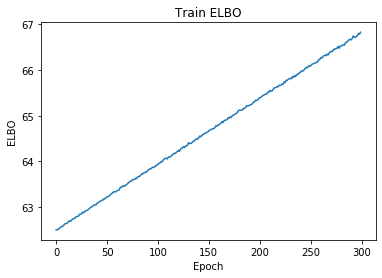

In [45]:
import matplotlib.pyplot as plt

plt.title("Train ELBO")
plt.xlabel("Epoch")
plt.ylabel("ELBO")

plt.plot(range(num_epochs), train_losses)

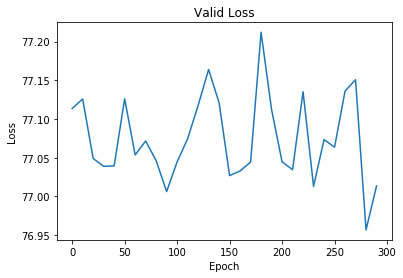

In [46]:
plt.title("Valid Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")


plt.plot([i*10 for i in range(int(num_epochs/val_test_frequency))], val_losses)